In [3]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema  # Local minima detection
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path
import os
import sys
sys.path.append(os.path.abspath("../"))
from utils.preprocess_signals import compute_relative_keypoints, normalize_signal, smooth_signal
from utils.load_data import load_json

In [4]:
# Print labeled cycles
print_cycle = False

In [5]:
# VIDEO_DIR = "/Users/emillundin/Desktop/Ski_project/Cut_videos/"  # Replace with your video file
# ANNO_DIR = "/Users/emillundin/Desktop/Ski_project/Annotations_from_CVAT/annotations_manually adjusted/annotations_manually_adjusted"
VIDEO_DIR = "e:\SkiProject\Cut_videos\Edited"  # Replace with your video file
# ANNO_DIR = "e:/SkiProject/AnnotationsByUs"
ANNO_DIR = "e:/SkiProject/annotations_test_DJI_0044/After_Mixed_level_output/coco_json"
video_id ="58" # 11, 13, 27, 32, 36, 42, 16_cut, 19_cut, 20_cut, 21_cut, 23_cut, 33, 34, 53 (annotations from finetuned model)
#file_path = os.path.join(ANNO_DIR, video_id + ".json")
file_path = os.path.join(ANNO_DIR, f"DJI_{int(video_id):04d}_coco.json")
json_path_labels = f"/Users/emillundin/Desktop/Ski_project/Annotated_cycles_backup/labeled_cycles_{video_id}.json"  # Update with correct path

<>:3: SyntaxWarning: invalid escape sequence '\S'
<>:3: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Emil L\AppData\Local\Temp\ipykernel_5496\55652038.py:3: SyntaxWarning: invalid escape sequence '\S'
  VIDEO_DIR = "e:\SkiProject\Cut_videos\Edited"  # Replace with your video file


In [6]:
# Function to process data from a dataset
def process_data(data, keypoint_indices):
    frames = sorted(set(anno["image_id"] for anno in data.get("annotations", [])))
    
    keypoint_movements = {}
    for joint, index in keypoint_indices.items():
        keypoints_per_joint = {"x": [], "y": []}
        
        for annotation in data.get("annotations", []):
            keypoints = annotation["keypoints"]
            
            # for the choosen reference joint we save the absolute values
            if joint == CHOOSEN_REF:
                absolute_keypoints = []
                for i in range(0, len(keypoints), 3):
                    x, y, v = keypoints[i:i+3]
                    if v == 0:
                        x, y = None, None
                    absolute_keypoints.append((x, y))
                joint_x, joint_y = absolute_keypoints[index]
            # for other joints we save keypoints relative to our reference joints
            else:
                relative_keypoints = compute_relative_keypoints(keypoints, keypoint_indices[CHOOSEN_REF])
                joint_x, joint_y = relative_keypoints[index]

            keypoints_per_joint["x"].append(joint_x)
            keypoints_per_joint["y"].append(joint_y)
            
        keypoint_movements[joint] = keypoints_per_joint

    return frames, keypoint_movements  

In [7]:
# Function to create a dynamic plot for the X values
def create_x_plot(frames, x_values, current_frame, min_indices):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    ax.plot(frames[:current_frame + 1], x_values[:current_frame + 1], color='red', label=CHOOSEN_JOINT + ' ' + CHOOSEN_DIM)

    # Mark the minimum points (from min_indices) with vertical lines
    for idx in min_indices:
        if idx <= current_frame:  # Only plot min_indices that have been reached
            ax.axvline(x=frames[idx], color='blue', linestyle='--', lw=1, zorder=5)  # Vertical dashed blue line


    ax.set_xlim([frames[0], frames[-1]])
    ax.set_ylim(min(x_values) - 1, max(x_values) + 1)
    ax.set_xlabel("Frame")
    ax.set_ylabel(CHOOSEN_DIM + " Position")
    ax.legend(loc="upper left")

    canvas = FigureCanvas(fig)
    canvas.draw()
    # plot_image = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8) # old version
    # plot_image = np.frombuffer(canvas.get_renderer().tostring_rgb(), dtype=np.uint8)
    plot_image = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    # plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # Reshape for RGBA
    plot_image = plot_image[:, :, :3]  # Keep only RGB channels
    plt.close(fig)

    return plot_image

In [8]:
def play_video_with_x_plot(video_path, frames, x_values_raw, x_values_smoothed, min_indices, cycles = None, frame_rate=30, output_path="output_video.mp4"):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define video writer (use same frame size & frame rate)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4 output
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

    frame_idx = 0  # Start from the first frame
    while frame_idx < total_frames:
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {frame_idx}.")
            break

        if cycles != None:
            # Find current cycle label
            current_label = ""
            current_cycle_id = "Cycle -"
            for cycle in cycles:
                cycle_id, start_frame, end_frame, label = cycle
                if start_frame <= frame_idx <= end_frame:
                    current_label = label
                    current_cycle_id = cycle_id
                    break 
        else:
            current_label = "-"
            current_cycle_id = "Cycle -"

        # Overlay X plot
        plot_image = create_x_plot(frames, x_values_smoothed, frame_idx, min_indices)
        plot_height, plot_width = plot_image.shape[:2]
        plot_resized = cv2.resize(plot_image, (frame_width // 3, int(plot_height * (frame_width // 3) / plot_width)))

        # Overlay plot on frame
        roi = frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:]
        overlayed_frame = cv2.addWeighted(roi, 0.2, plot_resized, 1, 0)
        frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:] = overlayed_frame

        # Display cycle label on the video
        label_text = f"{current_cycle_id} Label: {current_label}"
        cv2.putText(frame, label_text, (1420, 350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 5, cv2.LINE_AA)
        cv2.putText(frame, label_text, (1420, 350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show frame
        cv2.imshow("Video with X Plot", frame)

        # Write frame to output video
        out.write(frame)

        # Handle user input
        key = cv2.waitKey(1000 // frame_rate) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('r'):  # Restart video
            frame_idx = 0
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue
        
        frame_idx += 1  # Move to the next frame

    cap.release()
    out.release()  # Save the output video
    cv2.destroyAllWindows()
    print(f"Video saved to {output_path}")


In [9]:
CHOOSEN_JOINT = "LAnkle"
CHOOSEN_REF = "Hip"
CHOOSEN_DIM = "x"
MIN_OR_MAX = "max"
sigma_value = 2  # Adjust smoothing strength
order = 22 # How sensetive to find local minima
#LABELS = ["g2", "g3", "g4", "unknown"]
LABELS = {
    "2" : "gear2",
    "3" : "gear3",
    "4" : "gear4",
    "u" : "unknown"
}
CHOOSEN_KEYPOINTS = [CHOOSEN_JOINT, CHOOSEN_REF,"LShoulder","RShoulder","LElbow","RElbow","LWrist","RWrist","LHip","RHip","LKnee","RKnee","LAnkle","Head","Neck","LBigToe","RBigToe","LSmallToe","RSmallToe","LHeel","RHeel"]

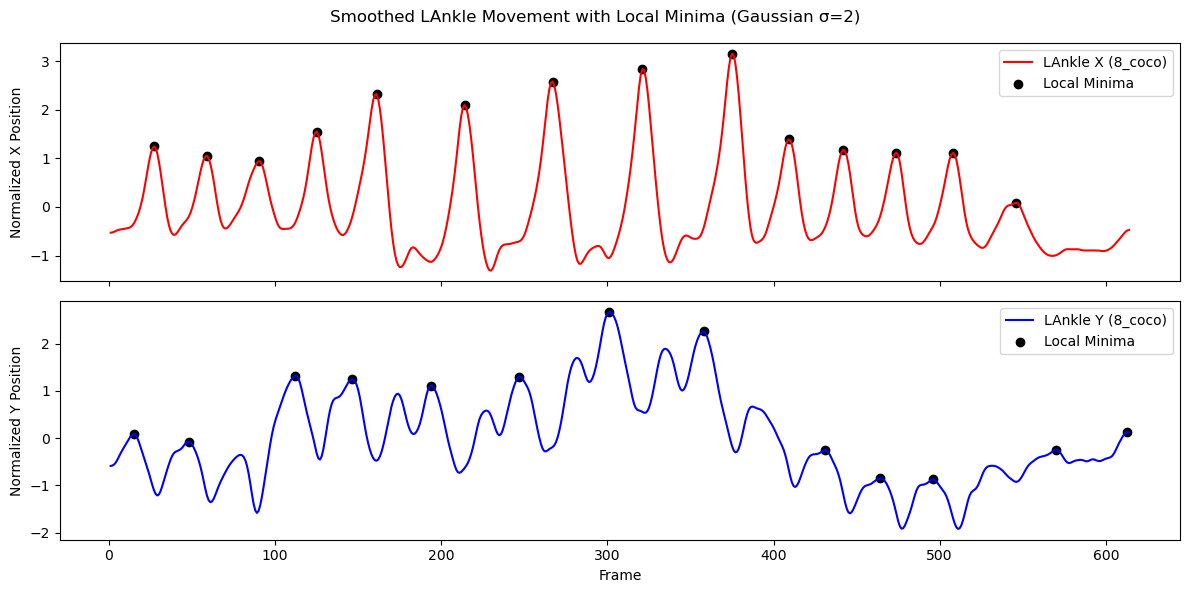

In [10]:
# Load JSON data
dataset = load_json(file_path)

# Extract keypoint labels (assumes same structure across files)
keypoint_labels = dataset["categories"][0]["keypoints"]
#hip_index = keypoint_labels.index("Hip")  # Find the index of the "Hip" keypoint
#lankle_index = keypoint_labels.index(CHOOSEN_JOINT)  # Find index for joint we choose
keypoint_indices = {joint: keypoint_labels.index(joint) for joint in CHOOSEN_KEYPOINTS}

# Process dataset, get keypoints and frames
frames, keypoints = process_data(dataset, keypoint_indices)

# Normalize and smooth all datasets
smoothed_normalized_keypoints = {"x": [], "y": []}
smoothed_normalized_keypoints["x"] = normalize_signal(keypoints[CHOOSEN_JOINT]["x"])
smoothed_normalized_keypoints["y"] = normalize_signal(keypoints[CHOOSEN_JOINT]["y"])

smoothed_normalized_keypoints["x"] = smooth_signal(smoothed_normalized_keypoints["x"], sigma=sigma_value)
smoothed_normalized_keypoints["y"] = smooth_signal(smoothed_normalized_keypoints["y"], sigma=sigma_value)

# Plot Joint movement (X and Y in separate plots)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

if MIN_OR_MAX == "max":
    # Detect local minima for X movement
    x_values = np.array(smoothed_normalized_keypoints["x"])
    x_min_indices = argrelextrema(x_values, np.greater, order=order)[0]  

    # Detect local minima for Y movement
    y_values = np.array(smoothed_normalized_keypoints["y"])
    y_min_indices = argrelextrema(y_values, np.greater, order=order)[0]  

elif MIN_OR_MAX == "min":
    # Detect local minima for X movement
    x_values = np.array(smoothed_normalized_keypoints["x"])
    x_min_indices = argrelextrema(x_values, np.less, order=order)[0]  

    # Detect local minima for Y movement
    y_values = np.array(smoothed_normalized_keypoints["y"])
    y_min_indices = argrelextrema(y_values, np.less, order=order)[0]  

else:
    raise ValueError("MIN_OR_MAX must be 'min' or 'max'")

# Plot choosen joint X movement
axs[0].plot(frames, x_values, label=f"{CHOOSEN_JOINT} X ({file_path[-11:-5]})", color="red")
axs[0].scatter(np.array(frames)[x_min_indices], x_values[x_min_indices], color="black", marker="o", label="Local Minima")
axs[0].set_ylabel("Normalized X Position")
axs[0].legend()

# Plot choosen joint Y movement
axs[1].plot(frames, y_values, label=f"{CHOOSEN_JOINT} Y ({file_path[-11:-5]})", color="blue")
axs[1].scatter(np.array(frames)[y_min_indices], y_values[y_min_indices], color="black", marker="o", label="Local Minima")
axs[1].set_ylabel("Normalized Y Position")
axs[1].set_xlabel("Frame")
axs[1].legend()

plt.suptitle(f"Smoothed {CHOOSEN_JOINT} Movement with Local Minima (Gaussian σ={sigma_value})")
plt.tight_layout()
plt.show()

In [11]:
def load_cycles(json_path):
    """
    Loads the JSON file and extracts start and end frames for each cycle along with its label.
    
    Parameters:
        json_path (str): Path to the JSON file.
    
    Returns:
        list of tuples: Each tuple contains (label, start_frame, end_frame).
    """
    with open(json_path, 'r') as file:
        data = json.load(file)

    cycle_info = []
    
    
    for cycle_label, values in data.items():
        if not values:
            continue  # Skip empty cycles
        
        # The frame indices are inferred from the length of the joint data
        start_frame = values["Start_frame"]
        end_frame = values["End_frame"]  # Get length from any joint data
        label = values["Label"]
        
        cycle_info.append((cycle_label, start_frame, end_frame, label))

    return cycle_info

# Example usage
if print_cycle:
    json_path_labels = f"/Users/emillundin/Desktop/Ski_project/Annotated_cycles_backup/labeled_cycles_{video_id}_cut.json"  # Update with correct path
    cycles = load_cycles(json_path_labels)

    for cycle in cycles:
        print(f"Cycle: {cycle[0]}, Start Frame: {cycle[1]}, End Frame: {cycle[2]}, Label: {cycle[3]}")

    print(cycles)

else:
    cycles = None


In [12]:
# Get the corresponding X values for each frame
#keypoints = {"LAnkle" : {"x": [], "y" : []}}
keypoint_values = {}
for joint, values in keypoints.items(): 
    if joint == CHOOSEN_REF:
        key_x, key_y = joint + "_x_ref", joint + "_y_ref"
    else:
        key_x, key_y = joint + "_x", joint + "_y"
    keypoint_values[key_x], keypoint_values[key_y] = values["x"], values["y"]
    
# keypoint_values = {"LAnkle_x": [], "LAnkle_y": [], ...}
    
x_values_smoothed = [smoothed_normalized_keypoints[CHOOSEN_DIM][i] for i in range(len(frames))]

# Video path
video_path = os.path.join(VIDEO_DIR, "DJI_00" + video_id + ".mp4")

if CHOOSEN_DIM == "x":
    min_indices = x_min_indices
else:
    min_indices = y_min_indices

print(keypoints)
    
# Run the function
play_video_with_x_plot(video_path, frames, keypoint_values, x_values_smoothed, min_indices, cycles, frame_rate=30, output_path=f"../output/{video_id}_{CHOOSEN_JOINT}_{CHOOSEN_DIM}_output.mp4")

{'LAnkle': {'x': [14.266357421875, 12.88232421875, 14.5030517578125, 15.0216064453125, 15.205810546875, 14.3365478515625, 16.8643798828125, 13.8099365234375, 15.4073486328125, 15.0931396484375, 16.454833984375, 15.3797607421875, 14.907958984375, 15.1134033203125, 17.156494140625, 17.3363037109375, 18.977783203125, 19.798095703125, 21.871337890625, 21.967041015625, 26.03515625, 29.4595947265625, 33.0379638671875, 35.7867431640625, 38.0838623046875, 43.0516357421875, 42.3717041015625, 43.0625, 39.9046630859375, 36.8353271484375, 33.0589599609375, 28.642578125, 25.693115234375, 21.6357421875, 16.4478759765625, 14.8306884765625, 13.1883544921875, 12.4813232421875, 12.920166015625, 13.1669921875, 12.3155517578125, 14.9664306640625, 17.0306396484375, 17.2117919921875, 15.6669921875, 18.70751953125, 17.1868896484375, 18.6629638671875, 18.48876953125, 20.6492919921875, 23.77587890625, 25.5330810546875, 25.85400390625, 30.4793701171875, 32.5169677734375, 36.0184326171875, 38.0921630859375, 39.1